In [9]:
# 2.3 ICESat-2 extraction, merging, filtering, exploring, mapping
REBUILD_CONDA_ENV = True

if REBUILD_CONDA_ENV:
    #### This notebook uses a DPS job to run extract_atl08.py to convert h5's to csv's, then appends all csv's into a pandas geodataframe.
    #### Returns: a pandas geodataframe that should hold the entire set of ATL08 data for this project
    #### Notes:
    ###### ISSUE: how to relaibly activate a conda env that can support this notebook.
    ###### Need to 'conda activate' an env that has geopandas - but where do I do this 'activate'. How does terminal env interact with nb?
    ###### Workaround: always do this to base:
    ! conda install -c conda-forge geopandas -y
    ! conda install -c conda-forge cartopy -y
    ! conda install -c conda-forge descartes -y
    ! conda install contextily --channel conda-forge -y
    ! conda install -c conda-forge matplotlib_scalebar -y
    ##https://www.essoar.org/doi/10.1002/essoar.10501423.1
    ##https://www.essoar.org/pdfjs/10.1002/essoar.10501423.1
    ##https://github.com/icesat2py/icepyx/blob/master/examples/ICESat-2_DEM_comparison_Colombia_working.ipynb
    ##https://github.com/ICESAT-2HackWeek/2020_ICESat-2_Hackweek_Tutorials
    ##https://icesat-2hackweek.github.io/learning-resources/logistics/schedule/
    ##https://github.com/giswqs/earthengine-py-notebooks

# Basic filtering themes in invoke below, and remove from extract_atl08.py
# snow has impact on errors - remove snow data (summer)
# msw = 0
# beams 1 & 5 strong (better radiometric perf, sensitive), then beam 3


Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - contextily


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    affine-2.3.0               |             py_0          16 KB  conda-forge
    contextily-1.1.0           |     pyhd8ed1ab_0          25 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    mercantile-1.1.6           |     pyh9f0ad1d_0          15 KB  conda-forge
    rasterio-1.0.28            |   py37hdff7cfa_1         8.2 MB  conda-forge
    snuggs-1.4.7               |             py_0           8 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.4 MB

The following NEW packages will be INSTALLED:

  aff

In [53]:
import geopandas as gpd
import descartes
import numpy as np
import seaborn as sb
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
import pandas as pd
import glob
import os
import random 

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import datetime
from matplotlib.colors import LinearSegmentedColormap
#from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

# Run extract_at08.py as a DPS job (see nb 1.3 for template of how this can be done)
DPS_OUTPUT_DIR = '/projects/r2d2/output_23'
DPS_OUTPUT_DIR = '/projects/jabba/dps_output'
DPS_OUTPUT_DIR = '/projects/jabba/data/bbox_alaska'
RUN_DPS = False

In [18]:
# Extraction
#
# DPS SUBMISSION ---- NOT YET WORKING ---- TODO: get this working with most up-to-date set of ATL08 for boreal
if RUN_DPS:
    # Here is where I submit a job 
    # identified with 'algo_id' (in yaml file)
    # that specifies a bash script (/jabba/code/dps_code/run_extract_atl08.sh) 
    # that will call the 'algorithm' (extract_atl08.py)
    # that takes an granule URL specifying a .H5 file : python /jabba/code/airborne/lvis_metrics.R ${GRANULE_URL} -output ??

    # Uses granule list from nb 2.1
    # CHANGE the submitJob args!
    for granule in granules_list_ATL08:
        submit_result = maap.submitJob(identifier="ice2", algo_id="ice2_h5tocsv_ubuntu", 
                                   version="master", 
                                   username="r2d2", 
                                   ice2_granules=granule)
        print(submit_result)
else:
    print("Not running DPS; probably because output from extract_atl08 DPS job already exists.")
    print(DPS_OUTPUT_DIR)

Not running DPS; probably because output from extract_atl08 DPS job already exists.
/projects/jabba/data/bbox_arymas


In [54]:
# Merging
#
# Merge all CSV from extract_at08.py into a dataframe
#
# NOTE: If the ATL08 subset files that we process with extract_atl08.py are h5 files (instead of CSVs), we need to update this.
#
# Find and delete any CSV that has a size of 0
! find $DPS_OUTPUT_DIR -maxdepth 1 -name "*.csv" -size 0 -delete

DO_SUBSET = False # <- set to True for testing
SUBSET_SIZE = 300

os.chdir(DPS_OUTPUT_DIR)
extension = 'csv'
all_atl08_csvs = [i for i in glob.glob('ATL08*.{}'.format(extension))]

print("# of ATL08 files: ",len(all_atl08_csvs))

# This could break if you randomly grab an incomplete or empty CSV
if DO_SUBSET:
    all_atl08_csvs = random.sample(all_atl08_csvs, SUBSET_SIZE)
    print("# of ATL08 files after test sample: ",len(all_atl08_csvs))

# Merge all files in the list
atl08 = pd.concat([pd.read_csv(f) for f in all_atl08_csvs ], sort=False)

# Get beam type
#atl08.loc[(atl08['orb_orient']==1) & (atl08['gt'].isin(["r"])),'beam_type'] = "Strong" 
#atl08['beam_type'] = atl08[orb_orient != 2] %>%
#    mutate(beam_type = case_when(
#                  orb_orient == 1 & grepl("r$", df_atl08$gt) == TRUE  ~ "Strong",
#                  orb_orient == 1 & grepl("r$", df_atl08$gt) == FALSE ~ "Weak",
#                  orb_orient == 0 & grepl("r$", df_atl08$gt) == TRUE  ~ "Weak",
#                  orb_orient == 0 & grepl("r$", df_atl08$gt) == FALSE ~ "Strong"
#                  )
# Probably not necessary
##atl08.to_csv( "atl08_merged.csv", index=False, encoding='utf-8-sig')

# of ATL08 files:  138


In [49]:
#atl08.seg_snow.nunique()
atl08.info()
#atl08.dtypes
# TODO: convert the yr and m cols to numeric (from object)
#atl08['m'] = atl08.m.astype(str).astype(int)

4

# of ATL08 columns:  54
There are 637505 observations in this dataframe.
Max lat: 72.92379760742188
Min lat: 52.7238655090332
Years:  ["b'2019'"]
Months:  ["b'6'"]

Example 1: Get only clear sky data, by year, with ht threshold.

There are 3187 observations in ice.
Filtering for clear skies and h_can < 60
Proportion of ice total satifying this filter: 0.07

There are 3273 observations in ice free water.
Filtering for clear skies and h_can < 60
Proportion of ice free water total satifying this filter: 0.08

There are 79187 observations in snow.
Filtering for clear skies and h_can < 60
Proportion of snow total satifying this filter: 0.02

There are 551858 observations in snow free land.
Filtering for clear skies and h_can < 60
Proportion of snow free land total satifying this filter: 0.08


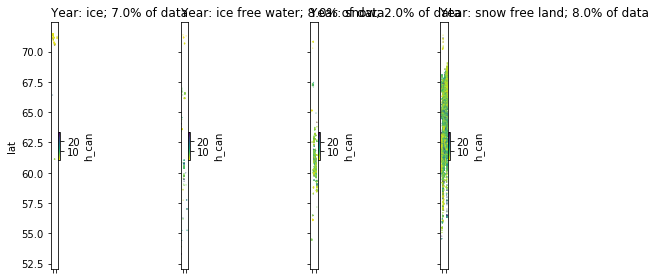

In [55]:
# Filtering, Exploring, & Mapping
#
# Here, we quickly map subsets of our ATL08 data
#
%matplotlib inline
print("# of ATL08 columns: ", len(atl08.columns))
print(f"There are {atl08.shape[0]} observations in this dataframe.")
#print("Col names: ", atl08.columns)
print("Max lat:",    atl08.lat.max())
print("Min lat:",    atl08.lat.min())
print("Years: ",     atl08.yr.unique())
print("Months: ",    atl08.m.unique())
print("\nExample 1: Get only clear sky data, by year, with ht threshold.")

fig, axes = plt.subplots(nrows=1, ncols=atl08.seg_snow.nunique(), figsize=(8, 4), sharex=True, sharey=True)
#ax0, ax1, ax2, ax3 = axes.flatten()
cmap_str = 'viridis_r'

SAMP_FRAC = 0.25 # Map just a portion of the data for speed

i=0
for group_name, group in atl08.groupby('seg_snow'):
    print(f"\nThere are {len(group)} observations in {group_name}.")
    print(f"Filtering for clear skies and h_can < 60")
    group_tmp = group[ 
                      (group.msw_flg == 0) & 
                      (group.h_can < 60)
                     ].sample(frac=SAMP_FRAC)
    prop_of_df = round(len(group_tmp) / len(group), 2)
    print(f"Proportion of {group_name} total satifying this filter: {prop_of_df}")
    group_tmp.plot(ax=axes[i], x='lon', y='lat', c='h_can', cmap = cmap_str, kind='scatter', s=0.05) # 
    axes[i].set_title("Year: "+group_name+"; "+str(round(prop_of_df*100,1)) +"% of data", loc='left')
    i+=1
plt.tight_layout() 

In [36]:
print(atl08.orb_orient.unique())

[1. 0.]


(0, 150)

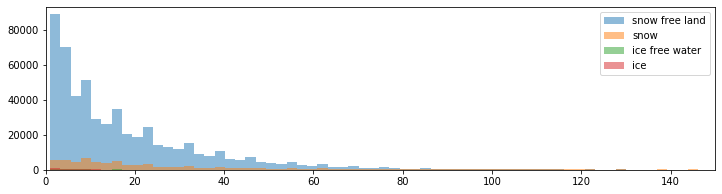

In [85]:
# Use the same bins for each
xmin = atl08.n_toc_ph.min()
xmax = atl08.n_toc_ph.max()
bins = np.linspace(xmin, xmax, 300)

# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(figsize=(12,3))


for i, seg_name in enumerate(atl08.seg_snow.unique()):
    ax.hist(atl08[atl08.seg_snow == seg_name].n_toc_ph, bins=bins, alpha=0.5, label=seg_name)
    ax.legend()

# same xlim for each so we can see differences
ax.set_xlim(0, 150)


In [8]:
# CREATE GEOPANDAS DATAFRAME WITH SPATIAL REF and sample a fractions of it.
#
SAMP_FRAC=0.1
atl08_gdf = GeoDataFrame(atl08, geometry=gpd.points_from_xy(atl08.lon, atl08.lat), crs='epsg:4326').sample(frac=SAMP_FRAC)
print(f"There are {atl08_gdf.shape[0]} ATL08 observations in this sampled ({100*SAMP_FRAC}%) Geodataframe.")
print(len(atl08_gdf.columns))
xmin, ymin, xmax, ymax = atl08_gdf.total_bounds

There are 1283596 ATL08 observations in this sampled (10.0%) Geodataframe.
56


In [9]:
# Define a boreal albers projection and map the geodataframe
boreal_alb = "+proj=aea +lat_1=50 +lat_2=70 +lat_0=60 +lon_0=-170 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
na_alb =     "+proj=aea +lat_1=50 +lat_2=70 +lat_0=60 +lon_0=-110 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

# Clip world to ATL08 gdf
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_atl08 = world.cx[xmin:xmax, ymin:ymax]
atl08_gdf_chull = atl08_gdf.unary_union.convex_hull

world_atl08 = world[world.intersects(atl08_gdf_chull)]
#NA = world[world['continent'] == 'North America'].to_crs(boreal_alb)

atl08_gdf_aea = atl08_gdf.to_crs(na_alb)
world_atl08_aea = world_atl08.to_crs(na_alb)

/projects/r2d2/output_23/atl08_alb_h_can_2018_2019_2020Dec11.png


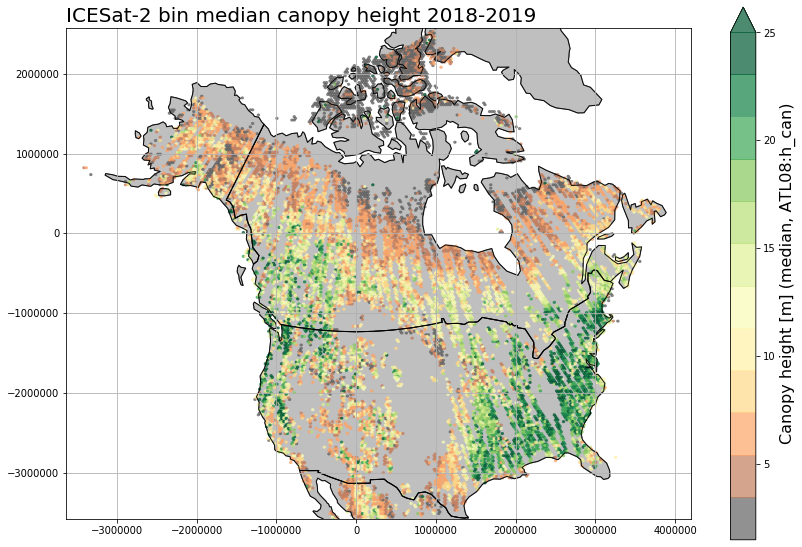

In [58]:
# Exploring ATL08 with hexbins
# All years
ax_map_title = "ICESat-2 bin median canopy height "
cbar_map_title = 'Canopy height [m] (median, ATL08:h_can)'

d = datetime.date.today().strftime("%Y%b%d")
# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(1,1, figsize=(14,14), sharex=True, sharey=True)

bbox = atl08_gdf_aea.total_bounds

group_tmp = atl08_gdf_aea[atl08_gdf_aea.msw_flg == 0] 

# My cmap
forest_ht_cmap = LinearSegmentedColormap.from_list('forest_ht', ['#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850','#005a32'], 12)

world_atl08_aea.plot(ax=ax, facecolor='grey', edgecolor='black',  alpha=0.5)
hb = ax.hexbin(group_tmp.geometry.x, group_tmp.geometry.y, C=group_tmp['h_can'], 
                   reduce_C_function=np.median, gridsize=250, cmap=forest_ht_cmap, vmax=25, mincnt=1, alpha=0.7)
world_atl08_aea.plot(ax=ax, facecolor='None', edgecolor='black',  alpha=0.9)

cbar = plt.colorbar(hb, extend='max', spacing='proportional', orientation='vertical', shrink=0.7, format="%.0f")
cbar.set_label(label = cbar_map_title, size=16)
   
ax.set_xlim(bbox[[0,2]])
ax.set_ylim(bbox[[1,3]])
ax.set_title(ax_map_title+"2018-2019", size=20, loc='left')
ax.grid()
print(os.path.join(DPS_OUTPUT_DIR, 'atl08_alb_h_can_2018_2019_'+d+'.png'))
plt.savefig(os.path.join(DPS_OUTPUT_DIR, 'atl08_alb_h_can_2018_2019_'+d+'.png'))
#ax.set(aspect='equal')

In [21]:
print(ctx.providers.keys())
print(ctx.providers.Stamen.keys())

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])
dict_keys(['Toner', 'TonerBackground', 'TonerHybrid', 'TonerLines', 'TonerLabels', 'TonerLite', 'Watercolor', 'Terrain', 'TerrainBackground', 'TopOSMRelief', 'TopOSMFeatures'])


Filtering by year for clear skies


/projects/contextily/contextily/tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling
/projects/contextily/contextily/tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling


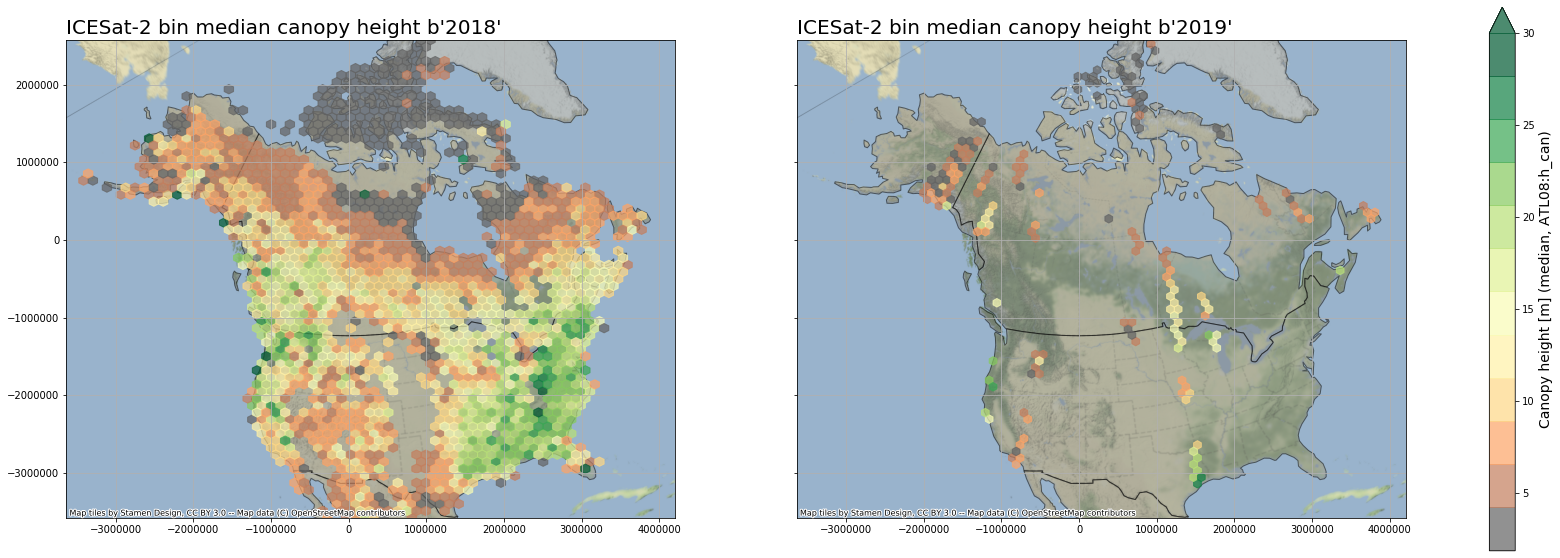

In [59]:
# Exploring ATL08 with hexbins
#

def add_basemap(ax, crs, zoom='auto'):
    ctx.add_basemap(ax=ax, crs=crs, source=ctx.providers.Stamen.TerrainBackground, zoom=zoom) # ctx.sources.ST_TERRAIN
    #Create a scalebar object, with scaling factor of 1.0 px, since we're using projected coordinate system with unit 1 m
    #scalebar = ScaleBar(1.0)
    #Add scalebar to axes
    #ax.add_artist(scalebar)

bbox = atl08_gdf_aea.total_bounds

# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(ncols=atl08_gdf_aea.yr.nunique(), figsize=(30,10), sharex=True, sharey=True)

print(f"Filtering by year for clear skies")
for i, (lab, group) in enumerate(atl08_gdf_aea.groupby('yr')):
    
    world_atl08_aea.plot(ax=ax[i], facecolor='grey', edgecolor='black',  alpha=0.5)
    
    group_tmp = group[group.msw_flg == 0]
    
    hb = ax[i].hexbin(group_tmp.geometry.x, group_tmp.geometry.y, C=group_tmp['h_can'], reduce_C_function=np.median, gridsize=60, cmap=forest_ht_cmap, vmax=30, mincnt=1, alpha=0.7)
    
    #world_atl08_aea.plot(ax=ax[i], facecolor='None', edgecolor='black',  alpha=0.9)
    
    ax[i].set_xlim(bbox[[0,2]])
    ax[i].set_ylim(bbox[[1,3]])
    ax[i].set_title(ax_map_title+lab, size=20, loc='left')
    ax[i].grid()
    ax[i].set(aspect='equal')
    add_basemap(ax[i], crs=na_alb)
    
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.5])
#cbar = fig.colorbar(hb, cax=cbar_ax)
#fig.colorbar(im, ax=axes.ravel().tolist())
cbar = plt.colorbar(hb, ax=ax.ravel().tolist(), extend='max', spacing='proportional', orientation='vertical', shrink=1, format="%.0f")
cbar.set_label(label = cbar_map_title, size=14)
#plt.tight_layout() 

In [ ]:
# Get a DEM for study domain
import os
import requests
import rasterio as rio
from rasterio import plot

#bbox_ll = [-150, 55, -115, 70]
#demtype = "SRTMGL3"
#url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff".format(demtype,*bbox_ll)
#response = requests.get(url)
#src = rio.open(response.content)